# Task 2. Examine your network

Examine the network and analyze how it processes the data.
Read in the trained network as the first step and print the model.

This should show you the structure of the network and the name of each layer.

In [1]:
import sys

import nbimporter
import Task1AE as Task1AENotebook
import Task1FG as Task1FGNotebook

import torch
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

from matplotlib import pyplot as plt


In [2]:
# 1. init network from the last saved
network = Task1FGNotebook.init_network()
print(network)

NeuralNetwork(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


## A. Analyze the first layer

Get the weights of the first layer.

When accessing a network, use the name of the layer as specified in the model printout. In this case, the name should be conv1. You access the weights using model.conv1.weight. The result is a tensor that should have the shape [10, 1, 5, 5]. That means there are ten filters, each 5x5 in size. To access the ith 5x5 filter, use weights[i, 0]. Print the filter weights and their shape.

Visualize the ten filters using pyplot.

You can use the pyplot functions figure, subplot, and imshow to make a 3x4 grid of figures such as the image below. If you set xticks and yticks to the empty list [], it will give you a cleaner plot.


10 of 5X5 filter: [[-0.00616714  0.00578109 -0.08054912  0.10950659  0.41173798]
 [ 0.07831135  0.43316355  0.16923112  0.08846094  0.23454832]
 [-0.00224269  0.10235976  0.22100337  0.0718096  -0.1296712 ]
 [-0.26006997 -0.0832911  -0.0555688  -0.14828    -0.24255326]
 [-0.51034886 -0.401768   -0.45485523 -0.30890504 -0.20821796]]
shape (5, 5)

10 of 5X5 filter: [[-0.20158444  0.05711301 -0.26724342 -0.02016171  0.1002958 ]
 [-0.12206714 -0.02081775 -0.08221278  0.05871231  0.24027872]
 [-0.19482088 -0.13398649 -0.1596901   0.07829323  0.37490866]
 [-0.01307653 -0.16718006  0.02244879 -0.02794683  0.35997638]
 [-0.42343807 -0.36791673 -0.25616246 -0.29661     0.32828805]]
shape (5, 5)

10 of 5X5 filter: [[ 0.26557007  0.17490964  0.21245003  0.14865388  0.3377855 ]
 [-0.07125001 -0.07694968 -0.2331604  -0.0853467  -0.14081877]
 [ 0.07397879 -0.0209775   0.08825143 -0.27354246 -0.25341928]
 [-0.11740911  0.15986098  0.0475588   0.09969246 -0.12245567]
 [-0.20219205 -0.20120636 -0.0419

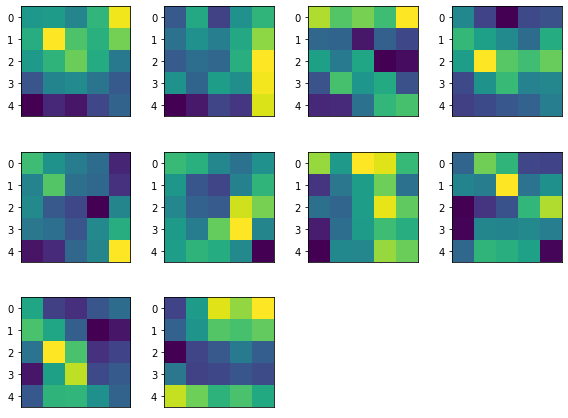

In [6]:
figure = plt.figure(figsize=(8, 8))
weights = network.conv1.weight

for i in range(10):
    # 1. Prepare grid
    # question why i cannot do 3X4
    plt.subplot(4, 4, i+1)
    plt.tight_layout()
   
    # 2. make sure the shape is 5X5 before doing imshow
    filter_matrix = weights[i][0].detach().numpy()
    print("\n10 of 5X5 filter:", filter_matrix)
    print("shape", filter_matrix.shape)
    
    # 3. show
    plt.imshow(filter_matrix, interpolation="none")
    plt.xticks([])

In [8]:
weights[i][0].detach().numpy().shape

(5, 5)

## B. Show the effect of the filters

Use OpenCV's filter2D function to apply the 10 filters to the first training example image.

Generate a plot of the 10 filtered images such as the one below. When working with the weights, you will need to tell pyTorch it does not need to calculate gradients. 


In [9]:
# 1. get the first training image (1X28X28) 
train_loader = Task1AENotebook.loadData(is_train=True)
img = Task1FGNotebook.load_firstN_data(train_loader, 1)[0]


In [10]:
# 2. apply first conv filter to the image
with torch.no_grad():
    output = network.conv1(img)
    print(output.shape)

torch.Size([10, 24, 24])


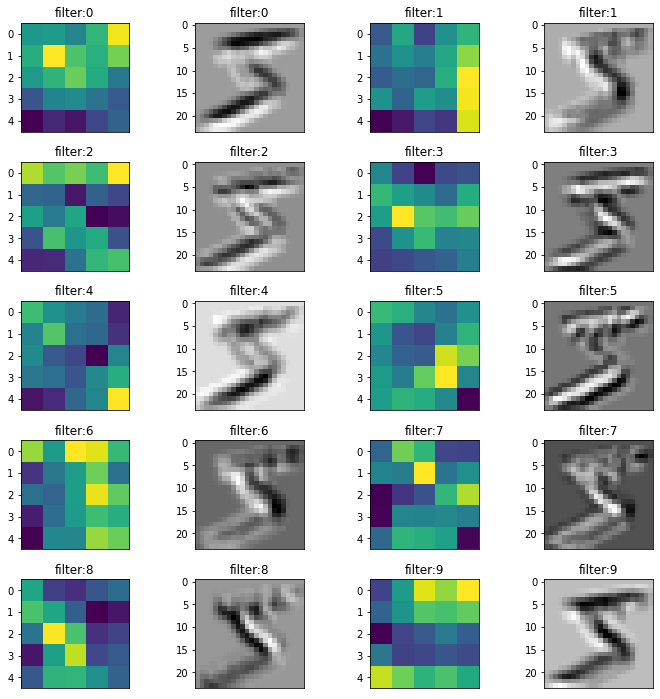

In [45]:
# 3. plot
figure = plt.figure(figsize=(10, 10))

# for matrix_index in range(10):
matrix_index = 0
plot_index = 1
while(matrix_index < 10):
    
    # 1. draw filter
    plt.subplot(5, 4, plot_index)
    plt.tight_layout()
    filter_matrix = weights[matrix_index][0].detach().numpy()
    plt.imshow(filter_matrix, interpolation="none")
    plt.title("filter:%d" %(matrix_index))
    plt.xticks([])
    
    plot_index+=1
    
    # 2. draw output
    plt.subplot(5, 4, plot_index)
    plt.tight_layout()
    output_matrix = output[matrix_index]
    plt.title("filter:%d" %(matrix_index))
    plt.imshow(output_matrix, cmap="gray",interpolation="none")
    plt.xticks([])
    
    matrix_index +=1
    plot_index+=1
    
    
    


In [ ]:
# question: what does the filter mean? the yellow is to detect the stroke ?